In [1]:
import os
import pandas as pd
from sklearn.externals import joblib
import numpy as np

#피쳐로 추출한 학습데이터 불러오기
#with_suspicious_perm.csv : 악성코드에서 자주 사용되는 권한만 사용
#악성앱과 정상앱 각각 불러오기
normal_path='./extract-from-apk-master/out/0-normal/with_suspicious_perm.csv'
malware_path='./extract-from-apk-master/out/1-malware/with_suspicious_perm.csv'

#csv로 읽기
normal_data=pd.read_csv(normal_path)
malware_data=pd.read_csv(malware_path)

#데이터 구조 확인
#normal_data : (4000, 141)
#malware_data : (1988,141)  2개는 dex파일 에러로 피쳐추출 실패
print(normal_data.shape, malware_data.shape)

(5261, 141) (2737, 141)


In [2]:
#악성, 정상앱 학습데이터 병합
data=pd.concat([normal_data, malware_data])

#데이터 구조 확인
#(5998,141)
print(data.shape)

(7998, 141)


In [3]:
#의미없는 피쳐 제거
data = data.iloc[:,(data.max()!=data.min()).tolist()]

#데이터 구조 확인
#(5998, 116)
print(data.shape)

(7998, 116)


In [4]:
from sklearn.utils import shuffle
data = shuffle(data)

In [5]:
data['size']=(data['size']-np.mean(data['size']))/np.std(data['size'])
data['ep']=(data['ep']-np.mean(data['ep']))/np.std(data['ep'])

In [6]:
y=data['label']
X=data.iloc[:,1:-1]

In [7]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

def do_XGBClassifier(x, y, test):
    model = XGBClassifier(max_depth=9,
                        nthread=4,
                        learning_rate=0.01,
                        objective='binary:logistic',
                        booster='gbtree',
                        n_estimators=2000 )
    model.fit(x,y)
    joblib.dump(model, 'XGB_model.pkl')
    
    y_pred=model.predict(X_test)
    
    return y_pred

In [8]:
from sklearn.ensemble import RandomForestClassifier

def do_Rf(x, y, test, ESTIMATOR=200):
    model = RandomForestClassifier(n_estimators=ESTIMATOR)
    model.fit(x, y)
    joblib.dump(model, 'RF_model.pkl')
    
    y_pred = model.predict(test)  
    
    return y_pred

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

def do_SVM(x, y, test, c, g):
    model = SVC(C=c, kernel='rbf', gamma=g)
    model.fit(x, y)
    joblib.dump(model, 'SVM_model.pkl')
    
    y_pred = model.predict(test)
    
    return y_pred

In [10]:
import math
import ast
import tensorflow as tf
from sklearn.model_selection import train_test_split

from datetime import datetime

now=datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir="tf_logs"
logdir="{}/{}-DNN_150150150_dropout005_l1l2_withtest_withfull/".format(root_logdir,now)

def do_DNN(x, y, x_test, y_test):
    #parameters
    n_inputs=x.shape[1] #suspiciou = 135 full=229
    n_hidden1=200
    n_hidden2=200
    n_outputs=2

    scale1=0.001
    scale2=0.001

    dropout_rate=0.1 # == 1 - keep_prob

    learning_rate=0.03

    n_epochs = 1000
    display_step=10
    batch_size = 128
    batch_num=x.shape[0]//batch_size

    tf.reset_default_graph()

    X=tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
    Y=tf.placeholder(tf.int64, shape=(None), name="Y")

    training=tf.placeholder_with_default(False, shape=(), name='training')

    with tf.name_scope("dnn"):
        X_drop=tf.layers.dropout(X, dropout_rate, training=training)
        hidden1 = tf.layers.dense(X_drop, n_hidden1, name="hidden1", activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(scale1, scale2))
        hidden1_dropp=tf.layers.dropout(hidden1, dropout_rate, training=training)
        hidden2 = tf.layers.dense(hidden1_dropp, n_hidden2, name="hidden2", activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(scale1, scale2))
        hidden2_dropp=tf.layers.dropout(hidden2, dropout_rate, training=training)
        logits = tf.layers.dense(hidden2_dropp, n_outputs, name="outputs")
    
    with tf.name_scope("loss"):
        xentropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y, logits=logits)
        loss=tf.reduce_mean(xentropy, name="loss")
        loss_summary = tf.summary.scalar('loss',loss)
    
    with tf.name_scope("train"):
        optimizer=tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)
    
    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(logits, Y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        accuracy_summary = tf.summary.scalar('accuracy',accuracy)
    
    merged = tf.summary.merge_all()

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        init.run()
    
        file_writer = tf.summary.FileWriter(logdir,tf.get_default_graph())
        max_acc = 0
    
        for epoch in range(n_epochs):
        
            avg_loss=0
            X_batches = np.array_split(x, batch_num)
            Y_batches = np.array_split(y, batch_num)
        
            for i in range(batch_num):
                batch_x, batch_y = X_batches[i], Y_batches[i]
            
                _, ls = sess.run([training_op, loss], feed_dict={X:batch_x, Y:batch_y, training:True})  #droup out
            
                avg_loss += ls / batch_num
        
            loss_train=loss.eval(feed_dict={X:x_test, Y:y_test})
            acc_train = accuracy.eval(feed_dict={X:x_test, Y:y_test})
            merged_train=merged.eval(feed_dict={X:x_test, Y:y_test})
        
            if epoch % display_step == 0:
                if acc_train > max_acc:
                    max_acc=acc_train
                
                print(epoch, "Avg Loss : ", avg_loss, "Train Loss : ", loss_train, " Train accuracy : ", acc_train, " Max accuracy : ", max_acc)
                file_writer.add_summary(merged_train, epoch)
    
        save_path=saver.save(sess, "./mymodel_final.ckpt")
        
    with tf.Session() as sess:
        saver.restore(sess, "./mymodel_final.ckpt")
        
        Z=logits.eval(feed_dict={X:x_test})
        y_pred=np.argmax(Z, axis=1)
        
    return y_pred

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

def search_XGB(x, y, test):
    parameters = {'booster':['gbtree', 'gblinear'],
                'nthread':[4], #when use hyperthread, xgboost may become slower
              #'objective':['binary:logistic'],
              'learning_rate': [0.05, 0.03, 0.025, 0.01], #so called `eta` value
              'max_depth': [7, 8, 9, 10],
              'n_estimators': [2000]} #number of trees, change it to 1000 for better results
                    
    scores = ['precision']#, 'recall']
    
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(XGBClassifier(), parameters, n_jobs=5, 
                   cv=5, 
                   scoring='roc_auc',
                   verbose=2, refit=True)
        clf.fit(x, y)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(test)
        print(classification_report(y_true, y_pred))
        print()

In [12]:
#search_XGB(X_train, y_train, X_test)

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#sklearn 라이브러리를 사용하여 학습데이터를 학습/테스트 데이터로 나눔 (10-Fold)
#악성앱과 정상앱이 2:1비율이므로 학습데이터 편향을 막기위해 Stratified K Fold를 사용
cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42) #Seed고정
cv.get_n_splits(X, y)

average_accuracy_XGB=0
average_accuracy_RF=0
average_accuracy_SVM=0
average_accuracy_DNN=0
average_accuracy_EN=0

#10-Fold한 학습/테스트 추출
for train_index, test_index in cv.split(X, y):
    X_train, X_test=X.iloc[train_index], X.iloc[test_index]
    y_train, y_test=y.iloc[train_index], y.iloc[test_index]
    #데이터구조 확인 (5398,) (600,), 마지막 2개 데이터셋은 각각 (5399,) (599,)
    #print(X_train.shape, X_test.shape) 
    
    #악성:정상 2:1로 나뉘었는지 확인
    #print(X_train[X_train['label']==0].shape, X_train[X_train['label']==1].shape, X_test[X_test['label']==0].shape, X_test[X_test['label']==1].shape)
    
    y_pred_DNN=do_DNN(X_train, y_train, X_test, y_test)
    
    cnf_matrix_DNN = confusion_matrix(y_test, y_pred_DNN)
    accuracy_DNN = accuracy_score(y_test, y_pred_DNN)
    average_accuracy_DNN+=accuracy_DNN
    
    print("DNN result")
    print(cnf_matrix_DNN)
    print(accuracy_DNN)
    
    y_pred_XGB=do_XGBClassifier(X_train, y_train, X_test)
    
    cnf_matrix_XGB = confusion_matrix(y_test, y_pred_XGB)
    accuracy_XGB = accuracy_score(y_test, y_pred_XGB)
    average_accuracy_XGB+=accuracy_XGB
    
    print("XGB result")
    print(cnf_matrix_XGB)
    print(accuracy_XGB)
    
    y_pred_RF=do_Rf(X_train, y_train, X_test, ESTIMATOR=200)
    
    cnf_matrix_RF = confusion_matrix(y_test, y_pred_RF)
    accuracy_RF = accuracy_score(y_test, y_pred_RF)
    average_accuracy_RF+=accuracy_RF
    
    print("RF result")
    print(cnf_matrix_RF)
    print(accuracy_RF)
    
    y_pred_SVM=do_SVM(X_train, y_train, X_test, 1000, 0.001)
    
    cnf_matrix_SVM = confusion_matrix(y_test, y_pred_SVM)
    accuracy_SVM = accuracy_score(y_test, y_pred_SVM)
    average_accuracy_SVM+=accuracy_SVM
    
    print("SVM result")
    print(cnf_matrix_SVM)
    print(accuracy_SVM)
    
    df=pd.DataFrame([y_pred_DNN,y_pred_RF,y_pred_SVM,y_pred_XGB], index=['DNN', 'RF', 'SVM', 'XGB'])
    df=df.transpose()
    
    df['EN']=df.apply(lambda x: 1 if (x['DNN']+x['RF']+x['SVM']+x['XGB'])/4>=0.5 else 0, axis=1)
    y_pred_EN=df['EN']
    
    cnf_matrix_EN = confusion_matrix(y_test, y_pred_EN)
    accuracy_EN = accuracy_score(y_test, y_pred_EN)
    average_accuracy_EN+=accuracy_EN
    
    print("EN result")
    print(cnf_matrix_EN)
    print(accuracy_EN)
    
print("XGB 평균 정확도 : ", average_accuracy_XGB/10)
print("RF 평균 정확도 : ", average_accuracy_RF/10)
print("SVM 평균 정확도 : ", average_accuracy_SVM/10)
print("DNN 평균 정확도 : ", average_accuracy_DNN/10)
print("앙상블 평균 정확도 : ", average_accuracy_EN/10)

0 Avg Loss :  0.37234565176601925 Train Loss :  0.11994456  Train accuracy :  0.9550562  Max accuracy :  0.9550562
10 Avg Loss :  0.11288840949003183 Train Loss :  0.120894656  Train accuracy :  0.9600499  Max accuracy :  0.9600499
20 Avg Loss :  0.10060649521515837 Train Loss :  0.11741943  Train accuracy :  0.9563046  Max accuracy :  0.9600499
30 Avg Loss :  0.08417692318159554 Train Loss :  0.117487945  Train accuracy :  0.96629214  Max accuracy :  0.96629214
40 Avg Loss :  0.11360372749290297 Train Loss :  0.1523194  Train accuracy :  0.9563046  Max accuracy :  0.96629214
50 Avg Loss :  0.08690616350421417 Train Loss :  0.15195087  Train accuracy :  0.9650437  Max accuracy :  0.96629214
60 Avg Loss :  0.0941747535086636 Train Loss :  0.1751669  Train accuracy :  0.9600499  Max accuracy :  0.96629214
70 Avg Loss :  0.08543939738800485 Train Loss :  0.1325715  Train accuracy :  0.9600499  Max accuracy :  0.96629214
80 Avg Loss :  0.0933099270997835 Train Loss :  0.1652669  Train accu

700 Avg Loss :  0.07578619599475393 Train Loss :  0.6565588  Train accuracy :  0.9650437  Max accuracy :  0.97003746
710 Avg Loss :  0.0746293791869123 Train Loss :  0.3763066  Train accuracy :  0.9625468  Max accuracy :  0.97003746
720 Avg Loss :  0.08378797147556076 Train Loss :  0.28932917  Train accuracy :  0.9600499  Max accuracy :  0.97003746
730 Avg Loss :  0.0774787343107164 Train Loss :  0.5440122  Train accuracy :  0.9612984  Max accuracy :  0.97003746
740 Avg Loss :  0.10235802200622857 Train Loss :  0.7486353  Train accuracy :  0.9600499  Max accuracy :  0.97003746
750 Avg Loss :  0.11456552332466734 Train Loss :  0.53406876  Train accuracy :  0.9600499  Max accuracy :  0.97003746
760 Avg Loss :  0.1284062860400549 Train Loss :  0.32988247  Train accuracy :  0.9650437  Max accuracy :  0.97003746
770 Avg Loss :  0.12817633928664565 Train Loss :  0.3457241  Train accuracy :  0.9600499  Max accuracy :  0.97003746
780 Avg Loss :  0.07533387976166395 Train Loss :  0.34896135  Tr

400 Avg Loss :  0.08516458385357899 Train Loss :  0.16554989  Train accuracy :  0.9675  Max accuracy :  0.97
410 Avg Loss :  0.06527644009994607 Train Loss :  0.15303978  Train accuracy :  0.955  Max accuracy :  0.97
420 Avg Loss :  0.08060978845294031 Train Loss :  0.15822661  Train accuracy :  0.95875  Max accuracy :  0.97
430 Avg Loss :  0.07296754100493018 Train Loss :  0.21158098  Train accuracy :  0.96625  Max accuracy :  0.97
440 Avg Loss :  0.14641232532449072 Train Loss :  0.20177719  Train accuracy :  0.96125  Max accuracy :  0.97
450 Avg Loss :  0.08763511608620839 Train Loss :  0.10136342  Train accuracy :  0.96875  Max accuracy :  0.97
460 Avg Loss :  0.06193848712635892 Train Loss :  0.12953106  Train accuracy :  0.96  Max accuracy :  0.97
470 Avg Loss :  0.0709313474362716 Train Loss :  0.17627095  Train accuracy :  0.9575  Max accuracy :  0.97
480 Avg Loss :  0.07779660737807194 Train Loss :  0.16023457  Train accuracy :  0.96  Max accuracy :  0.97
490 Avg Loss :  0.079

130 Avg Loss :  0.06142139218614568 Train Loss :  0.1968148  Train accuracy :  0.955  Max accuracy :  0.9675
140 Avg Loss :  0.07444200318838867 Train Loss :  0.14585684  Train accuracy :  0.96125  Max accuracy :  0.9675
150 Avg Loss :  0.07977253507955799 Train Loss :  0.19083  Train accuracy :  0.9625  Max accuracy :  0.9675
160 Avg Loss :  0.07874555539871964 Train Loss :  0.17638978  Train accuracy :  0.95875  Max accuracy :  0.9675
170 Avg Loss :  0.07176652846724858 Train Loss :  0.18691106  Train accuracy :  0.96125  Max accuracy :  0.9675
180 Avg Loss :  0.07736733771993647 Train Loss :  0.2997717  Train accuracy :  0.94875  Max accuracy :  0.9675
190 Avg Loss :  0.06662260607949323 Train Loss :  0.32134154  Train accuracy :  0.96  Max accuracy :  0.9675
200 Avg Loss :  0.07474824616552464 Train Loss :  0.15826204  Train accuracy :  0.96375  Max accuracy :  0.9675
210 Avg Loss :  0.07582789237078812 Train Loss :  0.2191401  Train accuracy :  0.95  Max accuracy :  0.9675
220 Avg

870 Avg Loss :  0.0810759477317333 Train Loss :  0.41713676  Train accuracy :  0.95  Max accuracy :  0.9675
880 Avg Loss :  0.08338744615736816 Train Loss :  0.47126022  Train accuracy :  0.95  Max accuracy :  0.9675
890 Avg Loss :  0.07565188880211539 Train Loss :  0.56461656  Train accuracy :  0.96  Max accuracy :  0.9675
900 Avg Loss :  0.06492722821089308 Train Loss :  0.4634818  Train accuracy :  0.94  Max accuracy :  0.9675
910 Avg Loss :  0.088408131667945 Train Loss :  0.44976863  Train accuracy :  0.96  Max accuracy :  0.9675
920 Avg Loss :  0.11354664513575179 Train Loss :  0.5252592  Train accuracy :  0.95875  Max accuracy :  0.9675
930 Avg Loss :  0.09403526743075678 Train Loss :  0.8415416  Train accuracy :  0.9425  Max accuracy :  0.9675
940 Avg Loss :  0.09105307848325798 Train Loss :  0.40575957  Train accuracy :  0.95625  Max accuracy :  0.9675
950 Avg Loss :  0.10187101430658785 Train Loss :  0.44558823  Train accuracy :  0.95625  Max accuracy :  0.9675
960 Avg Loss :

590 Avg Loss :  0.1048208585873778 Train Loss :  0.32600665  Train accuracy :  0.95125  Max accuracy :  0.96625
600 Avg Loss :  0.06677535315975547 Train Loss :  1.3155656  Train accuracy :  0.95125  Max accuracy :  0.96625
610 Avg Loss :  0.05768939408673242 Train Loss :  0.24928714  Train accuracy :  0.96375  Max accuracy :  0.96625
620 Avg Loss :  0.09195048601499624 Train Loss :  0.4123456  Train accuracy :  0.955  Max accuracy :  0.96625
630 Avg Loss :  0.07422633632086217 Train Loss :  0.3734021  Train accuracy :  0.95875  Max accuracy :  0.96625
640 Avg Loss :  0.07332039987003165 Train Loss :  0.3656802  Train accuracy :  0.95875  Max accuracy :  0.96625
650 Avg Loss :  0.06002568433593425 Train Loss :  0.21763565  Train accuracy :  0.965  Max accuracy :  0.96625
660 Avg Loss :  0.08269869492921443 Train Loss :  0.22369298  Train accuracy :  0.95625  Max accuracy :  0.96625
670 Avg Loss :  0.08393897395581006 Train Loss :  0.17846222  Train accuracy :  0.96125  Max accuracy :  

310 Avg Loss :  0.07754005591518114 Train Loss :  0.41981754  Train accuracy :  0.9425  Max accuracy :  0.95625
320 Avg Loss :  0.06972968965835336 Train Loss :  0.45237365  Train accuracy :  0.9475  Max accuracy :  0.95625
330 Avg Loss :  0.06149497431969004 Train Loss :  1.0675783  Train accuracy :  0.93625  Max accuracy :  0.95625
340 Avg Loss :  0.075716284003907 Train Loss :  0.75474626  Train accuracy :  0.9425  Max accuracy :  0.95625
350 Avg Loss :  0.07090173144492189 Train Loss :  0.619221  Train accuracy :  0.94125  Max accuracy :  0.95625
360 Avg Loss :  0.06463548121973871 Train Loss :  0.77399886  Train accuracy :  0.9425  Max accuracy :  0.95625
370 Avg Loss :  0.13370271201711145 Train Loss :  0.5293352  Train accuracy :  0.9475  Max accuracy :  0.95625
380 Avg Loss :  0.07081926414476977 Train Loss :  0.7193482  Train accuracy :  0.95  Max accuracy :  0.95625
390 Avg Loss :  0.0816365270210164 Train Loss :  1.1830151  Train accuracy :  0.9325  Max accuracy :  0.95625
4

30 Avg Loss :  0.09823506438572495 Train Loss :  0.14738163  Train accuracy :  0.95875  Max accuracy :  0.95875
40 Avg Loss :  0.0958410956331396 Train Loss :  0.21996681  Train accuracy :  0.95625  Max accuracy :  0.95875
50 Avg Loss :  0.08441059001987533 Train Loss :  0.1555736  Train accuracy :  0.95625  Max accuracy :  0.95875
60 Avg Loss :  0.09326939893487309 Train Loss :  0.15136153  Train accuracy :  0.9625  Max accuracy :  0.9625
70 Avg Loss :  0.10434580401384405 Train Loss :  0.14560854  Train accuracy :  0.95375  Max accuracy :  0.9625
80 Avg Loss :  0.08827935495147748 Train Loss :  0.19383356  Train accuracy :  0.96125  Max accuracy :  0.9625
90 Avg Loss :  0.09274335780979268 Train Loss :  0.21826115  Train accuracy :  0.95125  Max accuracy :  0.9625
100 Avg Loss :  0.10880502981932037 Train Loss :  0.18393017  Train accuracy :  0.95625  Max accuracy :  0.9625
110 Avg Loss :  0.08439267998827356 Train Loss :  0.14055355  Train accuracy :  0.96  Max accuracy :  0.9625
12

770 Avg Loss :  0.10153851012832353 Train Loss :  1.1644766  Train accuracy :  0.9575  Max accuracy :  0.96625
780 Avg Loss :  0.28740829645123867 Train Loss :  0.3162623  Train accuracy :  0.9575  Max accuracy :  0.96625
790 Avg Loss :  0.07265072705091112 Train Loss :  0.6536463  Train accuracy :  0.9625  Max accuracy :  0.96625
800 Avg Loss :  0.10203561106962816 Train Loss :  0.46715027  Train accuracy :  0.9425  Max accuracy :  0.96625
810 Avg Loss :  0.1215476825766798 Train Loss :  0.7353142  Train accuracy :  0.95375  Max accuracy :  0.96625
820 Avg Loss :  0.18479431896204399 Train Loss :  0.24059057  Train accuracy :  0.95  Max accuracy :  0.96625
830 Avg Loss :  0.1495132252707013 Train Loss :  0.23253307  Train accuracy :  0.96125  Max accuracy :  0.96625
840 Avg Loss :  0.07755708120696779 Train Loss :  0.30127665  Train accuracy :  0.95375  Max accuracy :  0.96625
850 Avg Loss :  0.07075169042218474 Train Loss :  0.60426795  Train accuracy :  0.96125  Max accuracy :  0.96

490 Avg Loss :  0.09278434767786946 Train Loss :  0.29192  Train accuracy :  0.955  Max accuracy :  0.9675
500 Avg Loss :  0.06638539597458606 Train Loss :  0.19653761  Train accuracy :  0.96  Max accuracy :  0.9675
510 Avg Loss :  0.0887651229277253 Train Loss :  0.16110711  Train accuracy :  0.955  Max accuracy :  0.9675
520 Avg Loss :  0.06296840045667652 Train Loss :  0.19985272  Train accuracy :  0.9575  Max accuracy :  0.9675
530 Avg Loss :  0.10317007236049645 Train Loss :  0.38613105  Train accuracy :  0.955  Max accuracy :  0.9675
540 Avg Loss :  0.0699477252284331 Train Loss :  0.19048886  Train accuracy :  0.95  Max accuracy :  0.9675
550 Avg Loss :  0.10129424778278917 Train Loss :  0.35563305  Train accuracy :  0.95375  Max accuracy :  0.9675
560 Avg Loss :  0.065388245075675 Train Loss :  0.25436297  Train accuracy :  0.95125  Max accuracy :  0.9675
570 Avg Loss :  0.09763012959488802 Train Loss :  0.16681719  Train accuracy :  0.95625  Max accuracy :  0.9675
580 Avg Loss

200 Avg Loss :  0.07059706278544452 Train Loss :  0.3489248  Train accuracy :  0.96245307  Max accuracy :  0.9674593
210 Avg Loss :  0.06712599551039082 Train Loss :  0.3832536  Train accuracy :  0.951189  Max accuracy :  0.9674593
220 Avg Loss :  0.07214650322150971 Train Loss :  0.362538  Train accuracy :  0.951189  Max accuracy :  0.9674593
230 Avg Loss :  0.057870531005651815 Train Loss :  0.28632796  Train accuracy :  0.95244056  Max accuracy :  0.9674593
240 Avg Loss :  0.08099708170630038 Train Loss :  0.33889782  Train accuracy :  0.95244056  Max accuracy :  0.9674593
250 Avg Loss :  0.06987770264303045 Train Loss :  0.34803164  Train accuracy :  0.9499374  Max accuracy :  0.9674593
260 Avg Loss :  0.06217166507017931 Train Loss :  0.39020807  Train accuracy :  0.9474343  Max accuracy :  0.9674593
270 Avg Loss :  0.07682410449654395 Train Loss :  0.2172195  Train accuracy :  0.9474343  Max accuracy :  0.9674593
280 Avg Loss :  0.07221841625869273 Train Loss :  0.22332527  Train

910 Avg Loss :  0.09441493554706021 Train Loss :  0.29829982  Train accuracy :  0.9474343  Max accuracy :  0.9674593
920 Avg Loss :  0.056685189899456305 Train Loss :  0.46563816  Train accuracy :  0.951189  Max accuracy :  0.9674593
930 Avg Loss :  0.07127724368391293 Train Loss :  0.3725925  Train accuracy :  0.95494366  Max accuracy :  0.9674593
940 Avg Loss :  0.06975125842395105 Train Loss :  0.36207178  Train accuracy :  0.951189  Max accuracy :  0.9674593
950 Avg Loss :  0.12159602590171355 Train Loss :  0.5248697  Train accuracy :  0.9474343  Max accuracy :  0.9674593
960 Avg Loss :  0.07252758402111278 Train Loss :  0.49597397  Train accuracy :  0.9461827  Max accuracy :  0.9674593
970 Avg Loss :  0.07552384187666965 Train Loss :  0.20968331  Train accuracy :  0.95369214  Max accuracy :  0.9674593
980 Avg Loss :  0.06772848887235992 Train Loss :  0.58292127  Train accuracy :  0.9461827  Max accuracy :  0.9674593
990 Avg Loss :  0.1123651791962662 Train Loss :  0.25107324  Trai

590 Avg Loss :  0.07749136896537884 Train Loss :  0.42331514  Train accuracy :  0.951189  Max accuracy :  0.9649562
600 Avg Loss :  0.0970467128790915 Train Loss :  0.91567737  Train accuracy :  0.95619524  Max accuracy :  0.9649562
610 Avg Loss :  0.07520839911220326 Train Loss :  0.51367605  Train accuracy :  0.9586984  Max accuracy :  0.9649562
620 Avg Loss :  0.06320092524401845 Train Loss :  0.54520184  Train accuracy :  0.95619524  Max accuracy :  0.9649562
630 Avg Loss :  0.06230691233317235 Train Loss :  0.72112113  Train accuracy :  0.9599499  Max accuracy :  0.9649562
640 Avg Loss :  0.07481923526419063 Train Loss :  0.6690333  Train accuracy :  0.9599499  Max accuracy :  0.9649562
650 Avg Loss :  0.057043976025722365 Train Loss :  0.7161486  Train accuracy :  0.9586984  Max accuracy :  0.9649562
660 Avg Loss :  0.06052990487244513 Train Loss :  0.42822334  Train accuracy :  0.95244056  Max accuracy :  0.9649562
670 Avg Loss :  0.06387489190923845 Train Loss :  0.4831599  Tra

270 Avg Loss :  0.08403922401235571 Train Loss :  0.20382899  Train accuracy :  0.9612015  Max accuracy :  0.96370465
280 Avg Loss :  0.08758503095512943 Train Loss :  0.14616257  Train accuracy :  0.95244056  Max accuracy :  0.96370465
290 Avg Loss :  0.07026501804856321 Train Loss :  0.20100185  Train accuracy :  0.96245307  Max accuracy :  0.96370465
300 Avg Loss :  0.06049767284587558 Train Loss :  0.18085665  Train accuracy :  0.9687109  Max accuracy :  0.9687109
310 Avg Loss :  0.06361868192574807 Train Loss :  0.21720403  Train accuracy :  0.9586984  Max accuracy :  0.9687109
320 Avg Loss :  0.0703664232610858 Train Loss :  0.2575721  Train accuracy :  0.9649562  Max accuracy :  0.9687109
330 Avg Loss :  0.08189619221125861 Train Loss :  0.24998696  Train accuracy :  0.9586984  Max accuracy :  0.9687109
340 Avg Loss :  0.08257252114292767 Train Loss :  0.30079213  Train accuracy :  0.96370465  Max accuracy :  0.9687109
350 Avg Loss :  0.09006472354355666 Train Loss :  0.20414835

980 Avg Loss :  0.08359992913236576 Train Loss :  0.7326379  Train accuracy :  0.96245307  Max accuracy :  0.97622025
990 Avg Loss :  0.05815113996089039 Train Loss :  0.49652672  Train accuracy :  0.9649562  Max accuracy :  0.97622025
INFO:tensorflow:Restoring parameters from ./mymodel_final.ckpt
DNN result
[[515  11]
 [ 16 257]]
0.9662077596996246
XGB result
[[507  19]
 [  9 264]]
0.9649561952440551
RF result
[[512  14]
 [ 11 262]]
0.9687108886107635
SVM result
[[510  16]
 [ 15 258]]
0.9612015018773467
EN result
[[508  18]
 [  7 266]]
0.9687108886107635
XGB 평균 정확도 :  0.9612393511552362
RF 평균 정확도 :  0.9641154478366373
SVM 평균 정확도 :  0.9624890394359991
DNN 평균 정확도 :  0.9539891927565514
앙상블 평균 정확도 :  0.9652407595558742


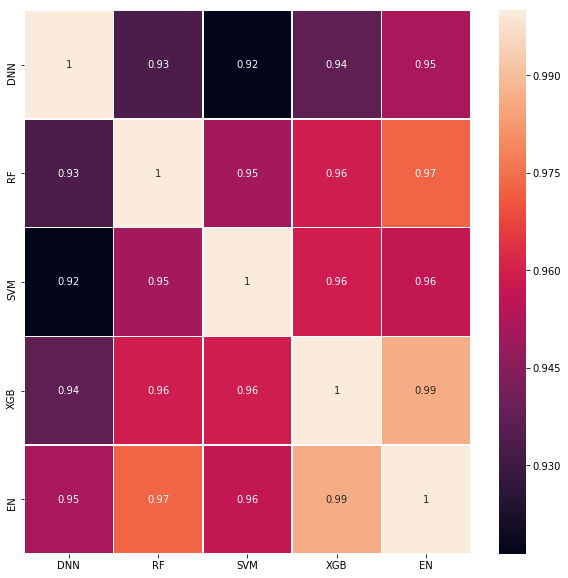

In [14]:
import seaborn as sns

fig, ax = pyplot.subplots(figsize=(10,10))         
sns.heatmap(df.corr(), annot=True, linewidth=.5, ax=ax)

In [15]:
y_pred_DNN=do_DNN(X, y, X_test, y_test)
y_pred_XGB=do_XGBClassifier(X, y, X_test)
y_pred_RF=do_Rf(X, y, X_test, ESTIMATOR=200)
y_pred_SVM=do_SVM(X, y, X_test, 1000, 0.001)
    
df=pd.DataFrame([y_pred_DNN,y_pred_RF,y_pred_SVM,y_pred_XGB], index=['DNN', 'RF', 'SVM', 'XGB'])
df=df.transpose()
    
df['EN']=df.apply(lambda x: 1 if (x['DNN']+x['RF']+x['SVM']+x['XGB'])/4>=0.5 else 0, axis=1)
y_pred_EN=df['EN']
    
cnf_matrix_EN = confusion_matrix(y_test, y_pred_EN)
accuracy_EN = accuracy_score(y_test, y_pred_EN)
    
print("EN result")
print(cnf_matrix_EN)
print(accuracy_EN)
    
print("최종 앙상블 정확도 : ",accuracy_EN)

0 Avg Loss :  0.29042202306370574 Train Loss :  0.12592341  Train accuracy :  0.951189  Max accuracy :  0.951189
10 Avg Loss :  0.11789486971834018 Train Loss :  0.08046331  Train accuracy :  0.9674593  Max accuracy :  0.9674593
20 Avg Loss :  0.10438614134346287 Train Loss :  0.06287901  Train accuracy :  0.9787234  Max accuracy :  0.9787234
30 Avg Loss :  0.11084171739076416 Train Loss :  0.0710046  Train accuracy :  0.9699625  Max accuracy :  0.9787234
40 Avg Loss :  0.08247653271762596 Train Loss :  0.053757984  Train accuracy :  0.9824781  Max accuracy :  0.9824781
50 Avg Loss :  0.0963975676004925 Train Loss :  0.06232254  Train accuracy :  0.9812265  Max accuracy :  0.9824781
60 Avg Loss :  0.09702918459210667 Train Loss :  0.045499977  Train accuracy :  0.98372966  Max accuracy :  0.98372966
70 Avg Loss :  0.08531292050235693 Train Loss :  0.046533745  Train accuracy :  0.9862328  Max accuracy :  0.9862328
80 Avg Loss :  0.08583462160200844 Train Loss :  0.046674155  Train accu

700 Avg Loss :  0.10683870357611487 Train Loss :  0.023736516  Train accuracy :  0.9887359  Max accuracy :  0.99749684
710 Avg Loss :  0.10107556192745126 Train Loss :  0.029829757  Train accuracy :  0.9924906  Max accuracy :  0.99749684
720 Avg Loss :  0.07368331249322621 Train Loss :  0.037244014  Train accuracy :  0.9824781  Max accuracy :  0.99749684
730 Avg Loss :  0.07748943456118144 Train Loss :  0.028007152  Train accuracy :  0.9862328  Max accuracy :  0.99749684
740 Avg Loss :  0.09846813655308177 Train Loss :  0.030248601  Train accuracy :  0.99374217  Max accuracy :  0.99749684
750 Avg Loss :  0.08111826787071845 Train Loss :  0.03535088  Train accuracy :  0.9899875  Max accuracy :  0.99749684
760 Avg Loss :  0.15827918996012977 Train Loss :  0.076825045  Train accuracy :  0.95369214  Max accuracy :  0.99749684
770 Avg Loss :  0.12180076160978887 Train Loss :  0.06133235  Train accuracy :  0.9862328  Max accuracy :  0.99749684
780 Avg Loss :  0.08576450133395773 Train Loss :